In [1]:
import theano
import theano.tensor as T
import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Multiply, Reshape, concatenate, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
# from evaluate import evaluate_model
# from Dataset import Dataset
from time import time
import sys
# import GMF, MLP
import argparse
import pandas as pd
import numpy as np
import random

import scipy.sparse as sp
import heapq
import math


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\Users\NTX550\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Arguments

In [2]:
# 데이터 input paht 
path = 'Data/'
# 데이터 셋 이름
dataset = 'ml-1m'
# 에포크 수 
epochs = 100
# 배치 사이즈 
batch_size = 256
# MF 모델의 embedding size.
num_factors = 8
#MLP의 각 레이어들의 사이즈. # 첫번째 레이어는 두개의 임베딩 결과를 concat 한것이기때문에 layers[0]/2가 embedding size가 되는것임. 
# "MLP layers. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size."
layers = [64,32,16,8]
#MF_embedding에서 값이 너무 커지는 것을 방지하기 위해 (overfitting 방지) 설정해주는 수.  Regularization for MF embeddings.
reg_mf = 0
#MLP의 각 레이어들의 정규화 수. 첫번째것이 Embedding 단계에서의 정규화 수. 위와 마찬가지로 overfitting 방지. Regularization for each MLP layer. reg_layers[0] is the regularization for embeddings.
reg_layers = [0,0,0,0]
# # train set에 사용할 neg sample의 수. point-wise learning이기 때문에 neg-sample을 따로 뽑아서 모아줘야 한다. "Number of negative instances to pair with a positive instance. "
num_neg = 4
# learning rate. hyper-parameter
lr = 0.001
# optimizer 설정. 'Specify an optimizer: adagrad, adam, rmsprop, sgd'
learner = 'adam'
# 각 iter 마다 출력할 길이. 'Show performance per X iterations' 보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태.
verbose = 1
# 트레인한 모델을 저장할지 말지. >0이면 저장. 
out = 1
# MF에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 'Specify the pretrain model file for MF part. If empty, no pretrain will be used'
mf_pretrain = ''
# MLP에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 'Specify the pretrain model file for MLP part. If empty, no pretrain will be used'
mlp_pretrain = ''


In [3]:
# def parse_args():
#     parser = argparse.ArgumentParser(description="Run NeuMF.")
#     parser.add_argument('--path', nargs='?', default='Data/',
#                         help='Input data path.')
#     parser.add_argument('--dataset', nargs='?', default='ml-1m',
#                         help='Choose a dataset.')
#     parser.add_argument('--epochs', type=int, default=100,
#                         help='Number of epochs.')
#     parser.add_argument('--batch_size', type=int, default=256,
#                         help='Batch size.')
#     parser.add_argument('--num_factors', type=int, default=8,
#                         help='Embedding size of MF model.')
#     parser.add_argument('--layers', nargs='?', default='[64,32,16,8]',
#                         help="MLP layers. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
#     parser.add_argument('--reg_mf', type=float, default=0,
#                         help='Regularization for MF embeddings.')                    
#     parser.add_argument('--reg_layers', nargs='?', default='[0,0,0,0]',
#                         help="Regularization for each MLP layer. reg_layers[0] is the regularization for embeddings.")
#     parser.add_argument('--num_neg', type=int, default=4,
#                         help='Number of negative instances to pair with a positive instance.')
#     parser.add_argument('--lr', type=float, default=0.001,
#                         help='Learning rate.')
#     parser.add_argument('--learner', nargs='?', default='adam',
#                         help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
#     parser.add_argument('--verbose', type=int, default=1,
#                         help='Show performance per X iterations')
#     parser.add_argument('--out', type=int, default=1,
#                         help='Whether to save the trained model.')
#     parser.add_argument('--mf_pretrain', nargs='?', default='',
#                         help='Specify the pretrain model file for MF part. If empty, no pretrain will be used')
#     parser.add_argument('--mlp_pretrain', nargs='?', default='',
#                         help='Specify the pretrain model file for MLP part. If empty, no pretrain will be used')
#     return parser.parse_args()

In [4]:
# args = parse_args()
num_epochs = epochs
# batch_size = args.batch_size
mf_dim = num_factors
# layers = eval(args.layers)
# reg_mf = args.reg_mf
# reg_layers = eval(args.reg_layers)
num_negatives = num_neg
learning_rate = lr
# learner = args.learner
# verbose = args.verbose
# mf_pretrain = args.mf_pretrain
# mlp_pretrain = args.mlp_pretrain

In [5]:
# 학습 시작 시점의 가중치를 잘 정해주어야 하기 때문에 학습할때마다 초기화(Weight initialization) 사용.
#  정규분포를 이루는 값을 랜덤하게 각 가중치에 배정해줌. 
def init_normal(shape, name=None):
    return initializers.normal(shape, scale=0.01, name=name)

In [6]:
#evaluation할 때 상위 몇개의 결과에 대해서 할 건지. 
topK = 10
#cpu개수 (multiprocessing.Pool에서 사용하는 num_thread로 넘겨줌)
evaluation_threads = 1 #mp.cpu_count()

# print("NeuMF arguments: %s " %(args))
model_out_file = 'Pretrain/%s_NeuMF_%d_%s_%d.h5' %(dataset, mf_dim, layers, time())

#### 데이터 전처리 - 미리 나눠놓은 데이터로 

In [7]:
# t1 = time()
# dataset = Dataset(args.path + args.dataset)
# train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
# num_users, num_items = train.shape
# print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d" 
#         %(time()-t1, num_users, num_items, train.nnz, len(testRatings)))

In [8]:
# 
ratingList = []
with open(path + dataset + ".test.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        user, item = int(arr[0]), int(arr[1])
        ratingList.append([user, item])
        line = f.readline()
ratingList

[[0, 25],
 [1, 133],
 [2, 207],
 [3, 208],
 [4, 222],
 [5, 396],
 [6, 74],
 [7, 91],
 [8, 514],
 [9, 659],
 [10, 820],
 [11, 829],
 [12, 844],
 [13, 105],
 [14, 519],
 [15, 218],
 [16, 246],
 [17, 228],
 [18, 770],
 [19, 641],
 [20, 1167],
 [21, 1195],
 [22, 934],
 [23, 603],
 [24, 872],
 [25, 352],
 [26, 839],
 [27, 1299],
 [28, 1458],
 [29, 1487],
 [30, 274],
 [31, 1521],
 [32, 459],
 [33, 91],
 [34, 1647],
 [35, 1071],
 [36, 808],
 [37, 244],
 [38, 237],
 [39, 1696],
 [40, 303],
 [41, 730],
 [42, 104],
 [43, 472],
 [44, 1772],
 [45, 1805],
 [46, 1624],
 [47, 360],
 [48, 968],
 [49, 1879],
 [50, 1595],
 [51, 788],
 [52, 245],
 [53, 1236],
 [54, 171],
 [55, 534],
 [56, 7],
 [57, 1719],
 [58, 170],
 [59, 488],
 [60, 2063],
 [61, 2119],
 [62, 743],
 [63, 876],
 [64, 693],
 [65, 41],
 [66, 82],
 [67, 19],
 [68, 485],
 [69, 237],
 [70, 317],
 [71, 18],
 [72, 1148],
 [73, 1646],
 [74, 939],
 [75, 267],
 [76, 445],
 [77, 1459],
 [78, 73],
 [79, 123],
 [80, 44],
 [81, 991],
 [82, 1904],
 [83

In [9]:
len(ratingList)

6040

In [10]:
testRatings = ratingList[:1000]

In [11]:
negativeList = []
with open(path + dataset + ".test.negative", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        negatives = []
        for x in arr[1: ]:
            negatives.append(int(x))
        negativeList.append(negatives)
        line = f.readline()
negativeList

[[1064,
  174,
  2791,
  3373,
  269,
  2678,
  1902,
  3641,
  1216,
  915,
  3672,
  2803,
  2344,
  986,
  3217,
  2824,
  2598,
  464,
  2340,
  1952,
  1855,
  1353,
  1547,
  3487,
  3293,
  1541,
  2414,
  2728,
  340,
  1421,
  1963,
  2545,
  972,
  487,
  3463,
  2727,
  1135,
  3135,
  128,
  175,
  2423,
  1974,
  2515,
  3278,
  3079,
  1527,
  2182,
  1018,
  2800,
  1830,
  1539,
  617,
  247,
  3448,
  1699,
  1420,
  2487,
  198,
  811,
  1010,
  1423,
  2840,
  1770,
  881,
  1913,
  1803,
  1734,
  3326,
  1617,
  224,
  3352,
  1869,
  1182,
  1331,
  336,
  2517,
  1721,
  3512,
  3656,
  273,
  1026,
  1991,
  2190,
  998,
  3386,
  3369,
  185,
  2822,
  864,
  2854,
  3067,
  58,
  2551,
  2333,
  2688,
  3703,
  1300,
  1924,
  3118],
 [1072,
  3154,
  3368,
  3644,
  549,
  1810,
  937,
  1514,
  1713,
  2186,
  660,
  2303,
  2416,
  670,
  1176,
  788,
  889,
  3120,
  2344,
  2525,
  3301,
  2055,
  1436,
  2630,
  11,
  2773,
  2176,
  1847,
  740,
  2332,

In [12]:
len(negativeList)

6040

In [13]:
testNegatives = negativeList[:1000]

In [14]:
num_users, num_items = 0, 0
with open(path + dataset + ".train.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        u, i = int(arr[0]), int(arr[1])
        num_users = max(num_users, u)
        num_items = max(num_items, i)
        line = f.readline()
# Construct matrix
mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
with open(path + dataset + ".train.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
        if (rating > 0):
            mat[user, item] = 1.0
        line = f.readline()
mat

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 994169 stored elements in Dictionary Of Keys format>

In [16]:
len(mat[:1000])

154177

In [22]:
mat[:1000]

<1000x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 154177 stored elements in Dictionary Of Keys format>

In [23]:
trainMatrix = mat[:1000]

In [24]:
num_users, num_items = trainMatrix.shape

In [25]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    #train set의 (user, 평가한 item)에 대해:
    for (u, i) in train.keys():
        #평점이 있는 조합은 다 positive로 넣고, 
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        #없는 조합 중 num_neg 수만큼 랜덤으로 뽑아서 다 negative로 넣자.
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            #train에 있으면 random num다시 뽑자~
            while (u, j)in train:
                j = np.random.randint(num_items)
            #이제 pos 조합에 다 sppend
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

In [26]:
user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)

In [27]:
len(user_input)

770885

#### 데이터 전처리 - raw 데이터로

In [100]:
# dataset = pd.read_csv('dataset/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])
# dataset

In [101]:
# ratings = dataset.copy()

In [102]:
# dataset

In [103]:
# #아이템_id로 컬럼명 변경
# ratings = ratings.rename(columns={'movie_id': 'item_id'})

In [104]:
# # set the num_users, items
# num_users = ratings['user_id'].nunique()+1
# num_items = ratings['item_id'].nunique()+1

In [105]:
# num_users

In [106]:
# #item과 user의 pool 만들자
# user_pool = set(ratings['user_id'].unique())
# item_pool = set(ratings['item_id'].unique())

In [107]:
# ratings

In [108]:
# #유저 id들의 중복제거 list를 만든다
# user_list = list(ratings['user_id'].drop_duplicates())
# user_list

In [109]:
# #raw data의 유저 id에 대해 새로운 순차 id를 부여하기 위해 user id-enumerate를 사용해 딕셔너리를 만든다
# user2id = {w: i for i, w in enumerate(user_list)}
# user2id

In [110]:
# #movie id에 대해서도 똑같이 해준다. 
# item_list = list(ratings['item_id'].drop_duplicates())
# item2id = {w: i for i, w in enumerate(item_list)}
# item2id

In [111]:
# #raw 유저id과 raw 아이템id에 대해 2dict를 이용해서 새로운 순차적 id로 바꿔주기
# ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
# ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])

In [112]:
# #rating 데이터를 float 형식으로
# ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
# #이걸 preprocess_ratings로 할당
# preprocess_ratings = ratings.copy()

###### 먼저 행동 데이터를 기반으로 train-test 분리를 하고, 
###### 그 다음으로 각 행마다 negative 데이터를 쌓는다. 

In [113]:
# '''각 유저별로 행동의 순서를 기록한 컬럼을 만든다: 뒤에 train-test split에 사용할 것
# why? random split을 하면 유저별로 잘 나눠졌는지 보장이 안되기 때문. 근데 train- test에 같은 id, item이 있어야 predict를 할 수 있음.'''
# preprocess_ratings['rank_latest'] = preprocess_ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
# preprocess_ratings

###### train-test split 구조: 
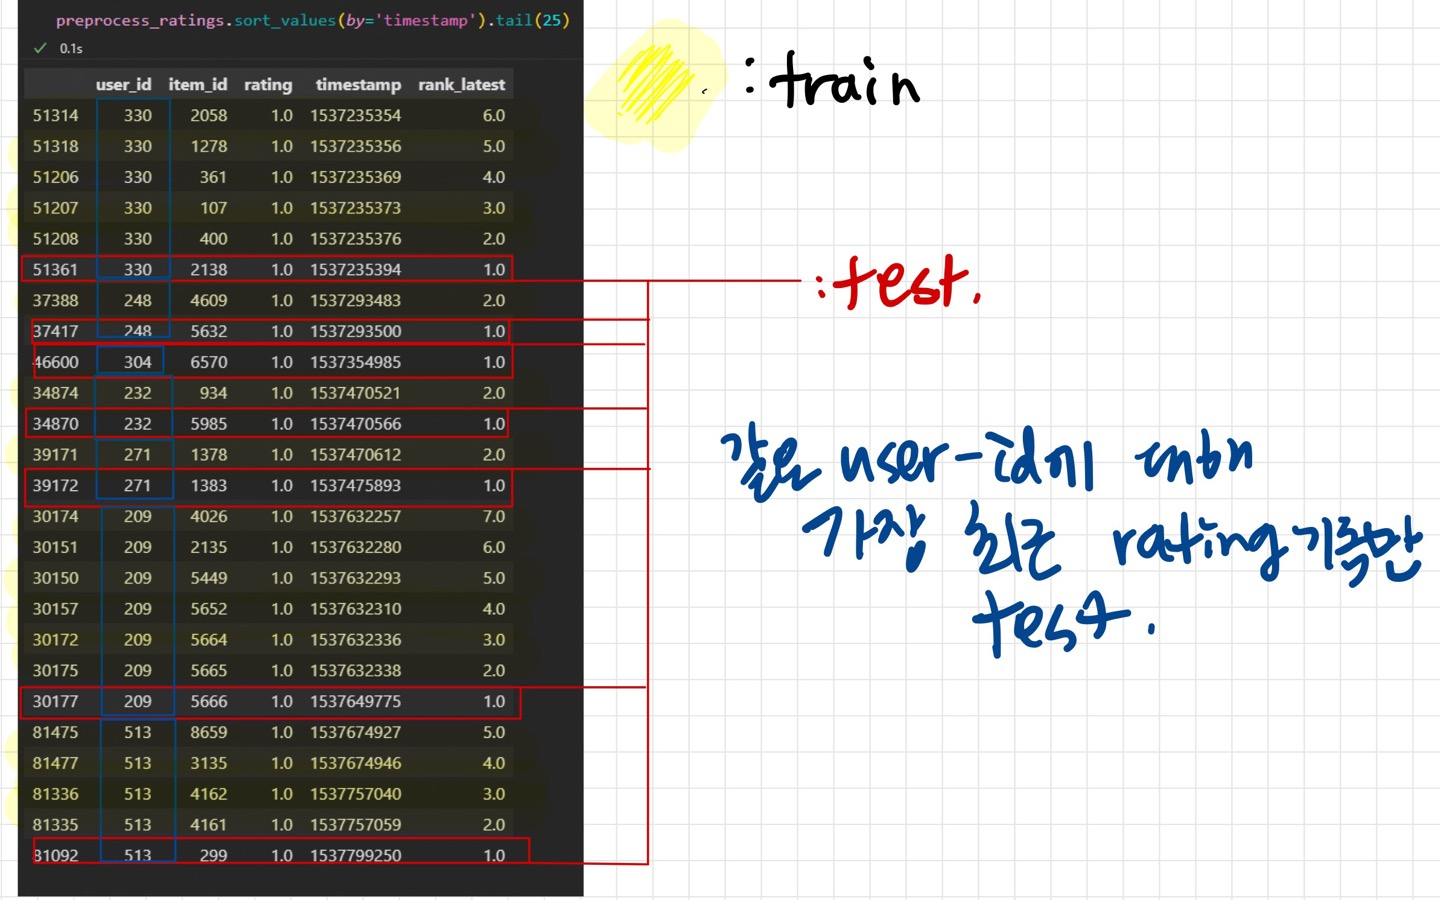

In [114]:
# preprocess_ratings.sort_values(by='timestamp').tail(25)

In [115]:
# #위에서 만든 rank_latest컬럼에서 마지막을 의미하는 1만 뽑아 test로, 그 이전 행동 데이터는 train으로 할당
# test = preprocess_ratings.loc[preprocess_ratings['rank_latest'] == 1]
# train = preprocess_ratings.loc[preprocess_ratings['rank_latest'] > 1]
# # assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
# #즉, train에서의 id와 test에서의 아이디들이 같아야 한다. 
# print(train['user_id'].nunique(), test['user_id'].nunique())
# #같지 않으면 그 row들 drop하는 코드 추가 

In [116]:
# #필요한 컬럼만 남기고 drop 
# train_ratings = train.drop(columns=['rank_latest', 'timestamp'])
# test_ratings = test.drop(columns=['rank_latest', 'timestamp'])
# train_ratings

In [117]:
# #test set에 사용할 negative test item 수를 정하자 "Number of negative samples for test set"
# num_ng_test = 100

In [118]:
# # train set에 사용할 neg sample의 수 "Number of negative samples for training set"
# num_ng = 4

In [119]:
# #우선 각 user_id에 대해 groupby - user가 행동한(buy/평점 등) itme을 set으로 묶어서 데이터프레임을 만든다
# interact_status = (
# 			preprocess_ratings.groupby('user_id')['item_id']
# 			.apply(set)
# 			.reset_index()
# 			.rename(columns={'item_id': 'interacted_items'}))

In [120]:
# ratings.groupby('user_id')['item_id'].apply(set).reset_index().rename(columns={'item_id': 'interacted_items'})

In [121]:
# #다음으로 item_pool에서 interacted_item를 뺀 set을 neative_items에 넣는다. 즉, 총 item중 내가 행동하지 않은 데이터를 뽑아내는것. 
# # why? pointwise 메서드를 하기 위해서는 pos/neg 데이터 나눠서 넣어줘야 함. 
# interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: item_pool - x)

# #그 데이터들 중, 미리 정해둔 수(num_ng_test)만큼 랜덤으로 sampling하자. 
# interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, num_ng_test))
# interact_status


In [122]:
# #negative df를 저장
# negatives = interact_status[['user_id', 'negative_items', 'negative_samples']]
# negatives

In [123]:
# print(len(item_pool))
# print(len(interact_status['interacted_items'][0]))
# print(len(interact_status['negative_items'][0]))
# print(len(interact_status['negative_samples'][0]))

In [124]:
# train_loader =data.get_train_instance()
# test_loader =data.get_test_instance()

In [125]:
# #위에서 만들어둔 train데이터에 negative item을 user_id를 key로 해서 merge한다. 
# train_ratings = pd.merge(train_ratings, negatives[['user_id', 'negative_items']], on='user_id')
# #negative_items에서 미리 설정해둔 숫자만큼(num_ng) random sampling을 해서 내가 행동하지 않은 item들을 negative data로 생성한다. 
# train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_ng))
# train_ratings

In [126]:
# train_ratings.tail(20)

In [127]:
# '''이제 만들어둔 train_ratings DF를 가지고 user, item, rating vector를 뽑아내기 위해 리스트로 뽑는다. 
# how? 
# train_ratings의 row를 한번 돌 때마다 :
# 1. 해당 row는 positive(1)값으로 넣고, 
# 2. neg_num 만큼 random sampling한 negatives들의 item 값들과 rating값을 negative값으로 넣어준다. 
# 이렇게 positive와 negative의 데이터를 함께 넣어줘야 point-wise하면서 각각의 유저에 대한 학습이 완료된다. 
# '''
# tr_users, tr_items, tr_ratings = [], [], []
# for row in train_ratings.itertuples():
#     tr_users.append(int(row.user_id))
#     tr_items.append(int(row.item_id))
#     tr_ratings.append(float(row.rating))
#     for i in range(num_ng):
#         tr_users.append(int(row.user_id))
#         tr_items.append(int(row.negatives[i]))
#         tr_ratings.append(float(0))  # negative samples get 0 rating

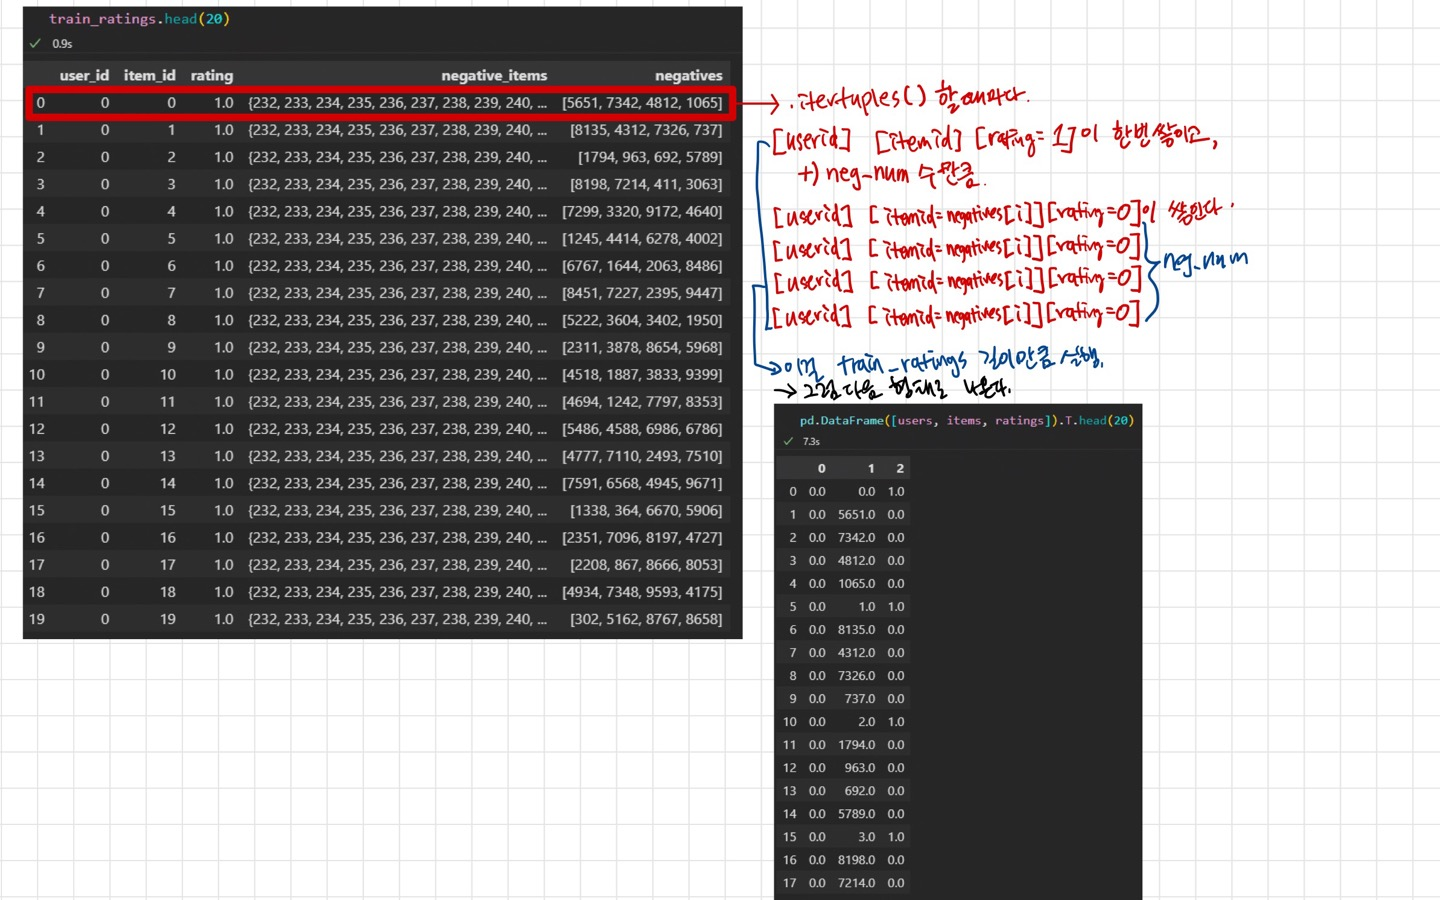

In [128]:
# len(tr_users)

In [129]:
# tr_items

In [130]:
# len(ratingList)

In [131]:
# negativeList


In [132]:
# tr_mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)

In [133]:
# tr_mat

In [134]:
# tr_users, tr_items, tr_ratings = [], [], []
# for row in train_ratings.itertuples():
#     tr_mat
#     tr_users.append(int(row.user_id))
#     tr_items.append(int(row.item_id))
#     tr_ratings.append(float(row.rating))
#     for i in range(num_ng):
#         tr_users.append(int(row.user_id))
#         tr_items.append(int(row.negatives[i]))
#         tr_ratings.append(float(0))  # negative samples get 0 rating

In [135]:
# #위에서 만들어둔 test데이터에 negative item을 user_id를 key로 해서 merge한다. 
# test_ratings = pd.merge(test_ratings, negatives[['user_id', 'negative_samples']], on='user_id')
# test_ratings

In [136]:
# '''이제 만들어둔 test_ratings DF를 가지고 user, item, rating vector를 뽑아내기 위해 리스트로 뽑는다. 
# how? 
# test_ratings의 row를 한번 돌 때마다 :
# 1. 해당 row는 positive(1)값으로 넣고, 
# 2. neg_num 만큼 random sampling한 negatives들의 item 값들과 rating값을 negative값으로 넣어준다. 
# 이렇게 positive와 negative의 데이터를 함께 넣어줘야 point-wise하면서 각각의 유저에 대한 학습이 완료된다. 
# '''
# ts_users, ts_items, ts_ratings = [], [], []
# for row in test_ratings.itertuples():
#     ts_users.append(int(row.user_id))
#     ts_items.append(int(row.item_id))
#     ts_ratings.append(float(row.rating))
#     for i in getattr(row, 'negative_samples'):
#         ts_users.append(int(row.user_id))
#         ts_items.append(int(i))
#         ts_ratings.append(float(0))

In [137]:
# #위에서 만든걸 원래 논문 형식에 맞춰서 만들어보자. 
# ts_ui, ts_neg =[], []
# ts_users, ts_items, ts_ratings = [], [], []
# for row in test_ratings.itertuples():
#     ts_ui.append([int(row.user_id),int(row.item_id)])
#     ts_users.append(int(row.user_id))
#     ts_items.append(int(row.item_id))
#     ts_ratings.append(float(row.rating))
#     for i in getattr(row, 'negative_samples'):
#         ts_neg.append([int(row.user_id),int(i)])
#         ts_users.append(int(row.user_id))
#         ts_items.append(int(i))
#         ts_ratings.append(float(0))

In [138]:
# test_ratings

#### 모델 쌓기

In [29]:
# layer 개수랑 layer의 초기화 설정값 개수랑 같은지 확인한다. 
num_layer = len(layers)
len(layers) == len(reg_layers)

True

In [30]:
# embedding 전 input 레이어를 만들자. Input variables
user_input = Input(shape=(1,), dtype= 'int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
print(type(user_input))
print(user_input)

<class 'keras.engine.keras_tensor.KerasTensor'>
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int32, name='user_input'), name='user_input', description="created by layer 'user_input'")


In [31]:
# 임베딩 레이어를 만들자. output 레이어의 사이즈가 다르게 설정해야 할 수 있기 때문에 따로 만든다. Embedding layer
MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf), input_length=1)
MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf), input_length=1)   

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = "mlp_embedding_user",
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)
MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = int(layers[0]/2), name = 'mlp_embedding_item',
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)   
print(MF_Embedding_User(user_input))

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 8), dtype=tf.float32, name=None), name='mf_embedding_user/embedding_lookup/Identity_1:0', description="created by layer 'mf_embedding_user'")


In [32]:
# GMF 부분 - 그냥 임베딩 거쳐서 flatten한 후에 아다마르 곱. MF part
mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

In [33]:
# MLP 부분 - 임베딩 거쳐서 flatten 한 후에 concat, 그리고 미리 설정해놓은 layer 파라미터에 맞게 학습. MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
mlp_vector = concatenate([mlp_user_latent, mlp_item_latent])
for idx in range(1, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    mlp_vector = layer(mlp_vector)

In [34]:
#MF와 MLP를 concat한다. 가중치를 줄수도 있음,,, Concatenate MF and MLP parts
#mf_vector = Lambda(lambda x: x * alpha)(mf_vector)
#mlp_vector = Lambda(lambda x : x * (1-alpha))(mlp_vector)
predict_vector = concatenate([mf_vector, mlp_vector])

In [35]:
# 마지막 예측 레이어. 이전에 concat한 벡터를 넣어 시그모이드 함수를 돌려준다. 
'''lecun = 유니폼이나 normal 분산에서 추출한 랜덤값으로 가중치를 초기화 시키되, 이 확률 분포를 fan in 값으로 조절하자는 아이디어이다. 
즉, input의 크기가 커질수록 초기화 값의 분산을 작게 만들자는 것이다. 
ReLU가 나오기 전에 사용한 방법으로 가우시안 분포에서 분산을 X의 원래 분산 정도로 보정한다.
'''
#  Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)

model = Model(inputs=[user_input, item_input], 
                outputs=prediction)

In [36]:
if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')

c:\Users\NTX550\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Evaluation 

In [37]:
#predict를 통해 top 10개 item 뽑은 리스트에 대해 positive data의 item이 있으면 1, 없으면 0 return
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

#predict를 통해 top 10개 item 뽑은 리스트에 대해 각각의 아이템이 positive data의 item와 같으면 랭킹에 따라 점수 반환, 없으면 0 return
'''1. NDCG는 0~1사이의 값을 갖게되는데 1과 가까울수록 우수한 추천시스템. 
2. 랭킹에 민감한 추천서비스의 경우 유용한 평가지표입니다.
3. 위에서 언급한 rating같이 연속형 변수도 가능하지만, Binary 변수 데이터에도 계산 가능'''

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [38]:
#아이템 하나에 대해 predcition score를 매핑해주는 함수를 만들자
def eval_one_rating(idx):
    #앞부분은 positive와 negative 셋을 맞춰주는 부분이다. raw 데이터 핸들링으로 이미 맞췄다면 굳이 필요없다. 
    #rating = positive data set ex. [609, 2833]
    rating = testRatings[idx]
    u = rating[0]
    gtItem = rating[1]
    #items = negative data의 item
    items = testNegatives[idx]
    #negative data item들에 positive data item을 추가한다. 
    items.append(gtItem)
    #그리고 positive data의 userid를 neg+pos 개수만큼 펼쳐준다.
    users = np.full(len(items), u, dtype = 'int32')
    #펼쳐준 userid와 itemid들(pos+neg)을 묶어서 predict해준다. 
    predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    # Get prediction scores
    map_item_score = {}
    #그리고 그 predict 점수와 item id를 매핑해준다. 
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    #그리고 정답 item은 빼준다.
    items.pop()
    # map_item_score 점수에 대해 미리 설정한 topK만큼 뽑아서 리스트 만들기
    ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get) 
    # 뽑은 10개 중 positive가 있는지 Hit Ratio랑 ndcg를 리턴해주기.
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

In [39]:
def evaluate_model(model, testRatings, testNegatives, toK, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    hits, ndcgs = [],[]
    # Single thread
    for idx in range(len(testRatings)):
        (hr,ndcg) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)      
    return (hits, ndcgs)

#### Pre-Train Model

###### 만약 pretrain 할거라면 train 시킨 것을 불러오면 됨. 

In [150]:
# ##GMF
# model_out_file = 'Pretrain/%s_MLP_%s_%d.h5' %(dataset, layers, time())

# regss = [0,0]
# def get_gmf_model(num_users, num_items, latent_dim, regss=[0,0]):
#     # Input variables
#     user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
#     item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

#     MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(regss[0]), input_length=1)
#     MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(regss[1]), input_length=1)   
    
#     # Crucial to flatten an embedding vector!
#     user_latent = Flatten()(MF_Embedding_User(user_input))
#     item_latent = Flatten()(MF_Embedding_Item(item_input))
    
#     # Element-wise product of user and item embeddings 
#     # predict_vector = merge([user_latent, item_latent], mode = 'mul')
#     predict_vector = Multiply([user_latent, item_latent])
    
#     # Final prediction layer
#     #prediction = Lambda(lambda x: K.sigmoid(K.sum(x)), output_shape=(1,))(predict_vector)
#     prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(predict_vector)
    
#     model = Model(input=[user_input, item_input], 
#                 output=prediction)

#     return model

# # Build model
# model = get_gmf_model(num_users, num_items, num_factors, regss)
# if learner.lower() == "adagrad": 
#     model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "rmsprop":
#     model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "adam":
#     model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
# else:
#     model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')
# print(model.summary())

# # Init performance
# t1 = time()
# (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
# hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
# #mf_embedding_norm = np.linalg.norm(model.get_layer('user_embedding').get_weights())+np.linalg.norm(model.get_layer('item_embedding').get_weights())
# #p_norm = np.linalg.norm(model.get_layer('prediction').get_weights()[0])
# print('Init: HR = %.4f, NDCG = %.4f\t [%.1f s]' % (hr, ndcg, time()-t1))

# # Train model
# best_hr, best_ndcg, best_iter = hr, ndcg, -1
# for epoch in range(epochs):
#     t1 = time()
#     # Generate training instances
#     user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)
    
#     # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                         np.array(labels), # labels 
#                         batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
#     t2 = time()
    
#     # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#                 % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

# print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
# if out > 0:
#     print("The best GMF model is saved to %s" %(model_out_file))

In [151]:
# #MLP
# model_out_file = 'Pretrain/%s_GMF_%d_%d.h5' %(dataset, num_factors, time())
# 
# def get_mlp_model(num_users, num_items, layers = [20,10], reg_layers=[0,0]):
#     assert len(layers) == len(reg_layers)
#     num_layer = len(layers) #Number of layers in the MLP
#     # Input variables
#     user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
#     item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

#     MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = 'user_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)
#     MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'item_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)   
    
#     # Crucial to flatten an embedding vector!
#     user_latent = Flatten()(MLP_Embedding_User(user_input))
#     item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
#     # The 0-th layer is the concatenation of embedding layers
#     vector = concatenate([user_latent, item_latent])
    
#     # MLP layers
#     for idx in range(1, num_layer):
#         layer = Dense(layers[idx], kernel_regularizer= L2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
#         vector = layer(vector)
        
#     # Final prediction layer
#     prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(vector)
    
#     model = Model(input=[user_input, item_input], 
#                   output=prediction)
    
#     return model

# # Build model
# model = get_mlp_model(num_users, num_items, layers, reg_layers)
# if learner.lower() == "adagrad": 
#     model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "rmsprop":
#     model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "adam":
#     model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
# else:
#     model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')    

# # Check Init performance
# t1 = time()
# (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
# hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
# print('Init: HR = %.4f, NDCG = %.4f [%.1f]' %(hr, ndcg, time()-t1))

# # Train model
# best_hr, best_ndcg, best_iter = hr, ndcg, -1
# for epoch in range(epochs):
#     t1 = time()
#     # Generate training instances
#     user_input, item_input, labels = get_train_instances(train, num_negatives)

#     # Training        
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                         np.array(labels), # labels 
#                         batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
#     t2 = time()

#     # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#                 % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

# print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
# if args.out > 0:
#     print("The best MLP model is saved to %s" %(model_out_file))


In [152]:
# def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
#     # MF embeddings
#     gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
#     gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
#     model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
#     model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
#     # MLP embeddings
#     mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
#     mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
#     model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
#     model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
#     # MLP layers
#     for i in range(1, num_layers):
#         mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
#         model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
#     # Prediction weights
#     gmf_prediction = gmf_model.get_layer('prediction').get_weights()
#     mlp_prediction = mlp_model.get_layer('prediction').get_weights()
#     new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
#     new_b = gmf_prediction[1] + mlp_prediction[1]
#     model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
#     return model

In [153]:
# # MF에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 쓸거면 위에서 저장한 파일명 가져오기.  'Specify the pretrain model file for MF part. If empty, no pretrain will be used'
# mf_pretrain = ''
# # MLP에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 쓸거면 위에서 저장한 파일명 가져오기. 'Specify the pretrain model file for MLP part. If empty, no pretrain will be used'
# mlp_pretrain = ''

In [154]:
# # Load pretrain model
# if mf_pretrain != '' and mlp_pretrain != '':
#     gmf_model = get_gmf_model(num_users,num_items,mf_dim)
#     gmf_model.load_weights(mf_pretrain)
#     mlp_model = get_mlp_model(num_users,num_items, layers, reg_layers)
#     mlp_model.load_weights(mlp_pretrain)
#     model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
#     print("Load pretrained GMF (%s) and MLP (%s) models done. " %(mf_pretrain, mlp_pretrain))

#### Init Performance

In [40]:
# Init performance
(hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('Init: HR = %.4f, NDCG = %.4f' % (hr, ndcg))
best_hr, best_ndcg, best_iter = hr, ndcg, -1
if out > 0:
    model.save_weights(model_out_file, overwrite=True)

Init: HR = 0.1090, NDCG = 0.0486


In [41]:
user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)

In [42]:
# Training model
#미리 정해놓은 epoch동안
for epoch in range(num_epochs):
    #시간 재기
    t1 = time()
    # Generate training instances
    #위에서 해주면 필요없는,,, 유저, 아이템, 레이블 로 나누고 pos + neg 조합으로 나누기
    # user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)
    
    # train 시켜주기... 한번 씩 num_epochs 수만큼 학습. Training
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                        np.array(labels), # labels 
                        batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
    t2 = time()
    
    # Evaluation
    if epoch % verbose == 0:
        #매 학습마다 evaluation model 사용. 결과와 loss 를 프린트
        (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
        hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
                % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        # 만약 hit ratio가 best hit ratio 보다 높으면 best hit raito 갱신
        if hr > best_hr:
            best_hr, best_ndcg, best_iter = hr, ndcg, epoch
            #만약 미리 정해놓은 수가 0보다 크면 갱신한 값을 저장. 안하고 싶으면 1
            if out > 0:
                model.save_weights(model_out_file, overwrite=True)

#베스트 에포크와 hr, ndcg점수 출력
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
#만약 미리 정해놓은 수가 0보다 크면 아래문 프린트. 안하고 싶으면 1
if out > 0:
    print("The best NeuMF model is saved to %s" %(model_out_file))

Iteration 0 [6.2 s]: HR = 0.4940, NDCG = 0.2882, loss = 0.3649 [68.0 s]
Iteration 1 [10.2 s]: HR = 0.5630, NDCG = 0.3333, loss = 0.3036 [72.7 s]
Iteration 2 [9.5 s]: HR = 0.6000, NDCG = 0.3540, loss = 0.2737 [71.5 s]
Iteration 3 [10.2 s]: HR = 0.6090, NDCG = 0.3595, loss = 0.2570 [76.4 s]
Iteration 4 [9.2 s]: HR = 0.6120, NDCG = 0.3627, loss = 0.2439 [71.5 s]
Iteration 5 [8.7 s]: HR = 0.6150, NDCG = 0.3626, loss = 0.2326 [79.9 s]
Iteration 6 [9.0 s]: HR = 0.6180, NDCG = 0.3612, loss = 0.2221 [67.4 s]
Iteration 7 [10.4 s]: HR = 0.6130, NDCG = 0.3599, loss = 0.2131 [73.2 s]
Iteration 8 [10.1 s]: HR = 0.6260, NDCG = 0.3654, loss = 0.2046 [72.8 s]
Iteration 9 [10.6 s]: HR = 0.6070, NDCG = 0.3545, loss = 0.1967 [74.7 s]
Iteration 10 [11.1 s]: HR = 0.6110, NDCG = 0.3550, loss = 0.1895 [75.6 s]
Iteration 11 [10.8 s]: HR = 0.6100, NDCG = 0.3495, loss = 0.1828 [74.0 s]
Iteration 12 [8.9 s]: HR = 0.5860, NDCG = 0.3379, loss = 0.1768 [52.3 s]
Iteration 13 [6.2 s]: HR = 0.6000, NDCG = 0.3429, loss

In [48]:
model.predict([np.array([0]), np.array([402])])

1/1 [==============================] - 0s 24ms/step


array([[1.3509443e-08]], dtype=float32)

In [76]:
rating = testRatings[990]
u = rating[0]
gtItem = rating[1]
#items = negative data의 item
items = testNegatives[idx]
#negative data item들에 positive data item을 추가한다. 
items.append(gtItem)
#그리고 positive data의 userid를 neg+pos 개수만큼 펼쳐준다.
users = np.full(len(items), u, dtype = 'int32')
#펼쳐준 userid와 itemid들(pos+neg)을 묶어서 predict해준다. 

In [77]:
gtItem

1556

In [78]:
predictions = model.predict([users, np.array(items)], 
                                batch_size=100, verbose=0)
predictions

array([[1.0419757e-15],
       [9.6683665e-16],
       [1.8188975e-05],
       [2.2100593e-01],
       [2.3555636e-32],
       [6.4612368e-17],
       [1.5909710e-29],
       [1.1292673e-02],
       [2.5234528e-16],
       [2.0190530e-02],
       [5.0003912e-15],
       [9.2271030e-01],
       [1.0170021e-11],
       [6.0330194e-25],
       [7.5421788e-16],
       [3.3434264e-09],
       [4.9139548e-02],
       [9.9780893e-01],
       [1.0790358e-17],
       [3.0799786e-17],
       [6.5277675e-36],
       [3.6566706e-18],
       [3.4704608e-19],
       [9.8598649e-20],
       [3.8559916e-03],
       [2.5109206e-17],
       [9.9114072e-01],
       [3.4626541e-14],
       [1.7813906e-02],
       [1.1260554e-06],
       [1.3470871e-03],
       [1.7520733e-02],
       [4.1416428e-12],
       [6.5455879e-16],
       [1.0000000e+00],
       [0.0000000e+00],
       [2.6786123e-10],
       [3.5875386e-14],
       [8.3044569e-08],
       [1.9293307e-07],
       [5.6389355e-13],
       [2.974910

In [79]:
# Get prediction scores
map_item_score = {}
#그리고 그 predict 점수와 item id를 매핑해준다. 
for i in range(len(items)):
    item = items[i]
    map_item_score[item] = predictions[i]
map_item_score

{3023: array([1.0419757e-15], dtype=float32),
 1489: array([9.668367e-16], dtype=float32),
 1916: array([1.8188975e-05], dtype=float32),
 1706: array([0.22100593], dtype=float32),
 1221: array([2.3555636e-32], dtype=float32),
 1191: array([6.461237e-17], dtype=float32),
 2671: array([1.590971e-29], dtype=float32),
 81: array([0.01129267], dtype=float32),
 2483: array([2.5234528e-16], dtype=float32),
 941: array([0.02019053], dtype=float32),
 841: array([5.0003912e-15], dtype=float32),
 1617: array([0.9227103], dtype=float32),
 1437: array([1.0170021e-11], dtype=float32),
 2700: array([6.0330194e-25], dtype=float32),
 1904: array([7.542179e-16], dtype=float32),
 1763: array([3.3434264e-09], dtype=float32),
 1181: array([0.04913955], dtype=float32),
 599: array([0.99780893], dtype=float32),
 2442: array([1.0790358e-17], dtype=float32),
 1656: array([3.0799786e-17], dtype=float32),
 1370: array([6.5277675e-36], dtype=float32),
 1171: array([3.6566706e-18], dtype=float32),
 1372: array([3.

In [80]:
#그리고 정답 item은 빼준다.
items.pop()
# map_item_score 점수에 대해 미리 설정한 topK만큼 뽑아서 리스트 만들기
ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get) 
ranklist

[2489, 1038, 1556, 3028, 2506, 55, 599, 1456, 23, 1617]

In [81]:
gtItem

1556